# Learning Computer Vision and NLP with Image Captioning

## Motivation
This project stems from a keen interest in exploring the intersection of Computer Vision and Natural Language Processing. It serves as a self-guided exploration into these advanced areas of machine learning, aiming to build foundational knowledge and practical skills in developing intelligent image captioning systems.

## Project Overview
This project focuses on building an image captioning model utilizing the MS COCO dataset. The aim is to construct a model capable of generating descriptive and precise captions for a given image, reflecting a nuanced understanding of visual data.

## Dataset
* **Name**: MS COCO Dataset (2017)
* **Contents**: Images along with corresponding captions.
* **Characteristics**: The dataset includes a diverse range of images and contexts to challenge the model's understanding of real-world visuals.

## Tools and Libraries
Below are the imports used in this project, which include necessary libraries and frameworks essential for handling data, building, and evaluating the model:

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CocoCaptions
from collections import Counter, defaultdict
import os, random
import pycocotools
from torchvision import transforms
from torchvision.transforms import ToPILImage
from PIL import Image
from torchtext.vocab import Vocab, vocab #Check for deletion
from torchtext.vocab import GloVe
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import json
import string
import warnings
from nltk.tokenize import word_tokenize
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.resnet import ResNet50_Weights
#from torchvision.models import resnet18, ResNet18_Weights
from nltk.translate.bleu_score import corpus_bleu
import torch.nn.functional as F


## Hyperparameters and Configuration Parameters
Below are the current hyperparameters and configuration parameters for the project. These values have been selected based on typical best practices and preliminary testing, but they may be adjusted as the project progresses to optimize the performance of the model.

In [2]:
config = {
    'batch_size': 64,
    'learning_rate': 1e-3,
    'epochs': 20,
    'num_workers' : 4,
    'encoder_dim': 2048, #Using ResNet50, if using a different CNN, may need to change.
    'embed_size': 300,
    'hidden_size': 512,
    'vocab_size': 24851, # This is the size of the intersection of GloVe 840B vocab and words used in MS COCO captions
    'num_layers': 1,  # Number of RNN layers
    'max_len': 50  # Maximum length of caption (based on MS COCO dataset, test max=49, val max=50)
}  

## Dataset Import and Custom Dataset Classes
In this section, the MS COCO dataset is imported for use in the project. This dataset includes a vast collection of images along with associated captions. To ensure the data has been imported correctly and to provide a visual understanding of the dataset, three random images and their corresponding captions are displayed below.

### Custom Dataset Class:
A custom dataset class is implemented to efficiently handle and process the images and captions, ensuring an organized and streamlined data pipeline.

In [3]:
home = os.path.expanduser("~")

data_paths = {
    'COCO': {
        'train': {
            'root': os.path.join(home, 'ML_project/Image-Captioner/data/train2017'),
            'annFile': os.path.join(home, 'ML_project/Image-Captioner/data/annotations/captions_train2017.json')
        },
        'val': {
            'root': os.path.join(home, 'ML_project/Image-Captioner/data/val2017'),
            'annFile': os.path.join(home, 'ML_project/Image-Captioner/data/annotations/captions_val2017.json')
        },
        'test': {
            'root': os.path.join(home, 'ML_project/Image-Captioner/data/test2017')
        }
    },
    'Flickr8k': {
        'root': os.path.join(home, 'ML_project/Image-Captioner/data/flickr8k/Images'),
        'annFile': os.path.join(home, 'ML_project/Image-Captioner/data/flickr8k/captions.txt')
    },
    'Flickr30k': {
        'root': os.path.join(home, 'ML_project/Image-Captioner/data/flickr30k/Images'),
        'annFile': os.path.join(home, 'ML_project/Image-Captioner/data/flickr30k/captions.txt')
    }
}


coco_dataset = CocoCaptions(root=data_paths['COCO']['train']['root'], annFile=data_paths['COCO']['train']['annFile'])
coco_dataset_validation = CocoCaptions(root=data_paths['COCO']['val']['root'], annFile=data_paths['COCO']['val']['annFile'])



#Custom Dataset to load the images and captions in, and easily apply preprocessing to images and captions
class CustomFlickrDataset(Dataset):
    def __init__(self, root, annFile, img_transform=None, text_transform=None, mode='train'):
        self.root = root
        self.img_transform = img_transform
        self.text_transform = text_transform
        self.vocab = None
        self.mode = mode

        # Load captions from the 'captions.txt' file
        with open(annFile, 'r') as file:
            lines = file.readlines()[1:]  # Skip the header
            # Using a defaultdict to group captions by their corresponding image
            captions_dict = defaultdict(list)
            for line in lines:
                image_path, caption = line.split(',', 1)
                captions_dict[image_path].append(caption.strip())

            # Now, self.imgs contains unique image filenames, and self.captions is a list of lists
            self.imgs = list(captions_dict.keys())
            self.captions = list(captions_dict.values())

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        if self.img_transform:
            img = self.img_transform(img)

        if self.mode == 'train':
            # Randomly select one caption for training
            caption = random.choice(self.captions[idx])
            if self.text_transform:
                caption = self.text_transform(caption)
        else:
            # Return all captions for evaluation
            caption = [self.text_transform(c) for c in self.captions[idx]]

        if self.vocab:
            if self.mode == 'train':
                caption = [self.vocab.get(token, self.vocab['<unk>']) for token in caption]
            else:
                caption = [[self.vocab.get(token, self.vocab['<unk>']) for token in c] for c in caption]

        return img, caption
    
    def set_vocab(self, vocab):
        self.vocab = vocab

    def set_mode(self, mode):
        if mode == 'train':
            self.mode = 'train'
        elif mode == 'eval':
            self.mode = 'eval'
        else:
            self.mode = None
            
#Custom Dataset to easily apply preprocessing to images and captions
class CustomCOCODataset(Dataset):
    def __init__(self, coco_dataset, img_transform=None, text_transform=None, mode='train'):
        self.coco_dataset = coco_dataset
        self.img_transform = img_transform
        self.text_transform = text_transform
        self.vocab = None  # Initially set vocab to None
        self.mode = mode  # 'train' or 'eval'

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, captions = self.coco_dataset[idx]
       
        if self.img_transform:
            img = self.img_transform(img)
        
        if self.mode == 'train':
            caption = random.choice(captions)  # Take the first caption for training
            if self.text_transform:
                caption = self.text_transform(caption)
        else:
            caption = [self.text_transform(c) for c in captions]  # Take all captions for evaluation

        if self.vocab:  # If vocab is available, convert tokens to indices
            if self.mode == 'train':
                caption = [self.vocab.get(token, self.vocab['<unk>']) for token in caption]
            else:
                caption = [[self.vocab.get(token, self.vocab['<unk>']) for token in c] for c in captions]


        return img, caption
    
    def set_vocab(self, vocab):
        self.vocab = vocab  # Set the vocab


loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


## Data Preprocessing

This section is dedicated to preparing the data for the model. The preprocessing steps are crucial for enhancing the model's performance and efficiency. Below are the steps undertaken for both image and caption data:

### Image Preprocessing:
1. **Resizing:** The images are resized to ensure uniformity in the dataset.
2. **Normalization:** Images are normalized to make the training process more stable and faster.

### Caption Preprocessing:
1. **Adding Tokens:** Each caption is appended with `<start>` and `<end>` tokens to signify the beginning and the end of the sentence.
2. **Lowercasing:** All characters in the captions are converted to lowercase to maintain consistency.
3. **Removal of Punctuation:** Unnecessary punctuation is removed from the captions.
4. **Tokenization:** Captions are broken down into individual words, creating a list of tokens.

In [4]:
# Define the image transformations
img_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

#Preprocessing the Captions to be ready for embedding with GloVe
def caption_preprocess(caption):
    # Add start and end tokens
    caption = '<start> ' + caption + ' <end>'
    
    # Convert to lowercase
    caption = caption.lower()
    
    # Remove punctuation
    remove_punct = string.punctuation.replace('<', '').replace('>', '')
    translator = str.maketrans('', '', remove_punct)
    caption = caption.translate(translator)
    
    # Tokenization (split the caption into words)
    tokens = caption.split()
    
    return tokens



#dataset = CustomCOCODataset(coco_dataset=coco_dataset, img_transform=img_preprocess, text_transform=caption_preprocess, mode='notTrain')

dataset = CustomFlickrDataset(data_paths['Flickr8k']['root'], data_paths['Flickr8k']['annFile'],img_transform=img_preprocess,text_transform=caption_preprocess, mode='train')
eval_dataset = CustomFlickrDataset(data_paths['Flickr8k']['root'], data_paths['Flickr8k']['annFile'],img_transform=img_preprocess,text_transform=caption_preprocess, mode='eval')



### Vocabulary Initalization and Embedding Preparation

In [5]:
### Vocab-related helper functions

#Save the vocabulary to a JSON file and the embeddings to a PyTorch file.
def save_vocab_and_embeddings(vocab, embeddings, vocab_path, embeddings_path):

    with open(vocab_path, 'w') as f:
        json.dump(vocab, f)
    
    torch.save(embeddings, embeddings_path)

#Load the vocabulary from a JSON file and the embeddings from a PyTorch file.
def load_vocab_and_embeddings(vocab_path, embeddings_path):

    with open(vocab_path, 'r') as f:
        vocab = json.load(f)
    
    embeddings = torch.load(embeddings_path)
    
    return vocab, embeddings

#Function to pad captions to the max caption length in the batch
def collate_fn(data):
    # data is a list of tuples (image, caption)
    images, captions = zip(*data)
    
    # Convert images to a single tensor
    images = torch.stack(images)  # Use torch.stack to convert tuple of tensors to a single tensor
    
    # Find the maximum caption length in the batch
    max_len = max(len(cap) for cap in captions)

    # Pre-allocate a tensor filled with padding tokens for all captions
    captions_padded = torch.full((len(captions), max_len), word_to_idx['<pad>'], dtype=torch.long)
    
    # Fill in the tensor with the actual caption values
    for idx, cap in enumerate(captions):
        captions_padded[idx, :len(cap)] = torch.LongTensor(cap)

    return images, captions_padded
               

### Building the vocab
'''
glove = GloVe(name="840B", dim=config['embed_size'])

# GloVe's vocabulary and embeddings - for building Vocab
glove_vocab = glove.itos  # list of words, indexed by their position in the vocabulary
embeddings = glove.vectors  # the actual vectors, indexed in the same way as glove_vocab



# Calculate the mean of all embeddings for certain special tokens
mean_embedding = torch.mean(embeddings, dim=0, keepdim=True)
zero_embedding = torch.zeros(1, config['embed_size'])

# Special tokens and their initializations
special_tokens_init = {
    '<pad>': zero_embedding,
    '<unk>': zero_embedding,
    '<end>': mean_embedding,
    '<start>': mean_embedding
}

word_to_idx = {word: idx for idx, word in enumerate(glove_vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(str(len(word_to_idx)) + " "+ str(len(idx_to_word)))


coco_vocab = set()

# Update the vocabulary set with unique words from each caption in the dataset
for _, captions in dataset:
    for caption in captions:
        coco_vocab.update(caption)


# Find the intersection of words between GloVe and COCO captions
final_vocab_set = coco_vocab.intersection(set(glove_vocab))

# Convert the set to a list and sort it (for determinism)
final_vocab = sorted(list(final_vocab_set))

final_vocab = list(special_tokens_init.keys()) + final_vocab

# Now create the word-to-index and index-to-word mappings and the reduced embeddings tensor
reduced_embeddings = []

word_to_idx_reduced = {word: idx for idx, word in enumerate(final_vocab)}
idx_to_word_reduced = {idx: word for word, idx in word_to_idx_reduced.items()}

#Append special tokens, then embeddings from COCO captions if contained in the glove vocab
for word in final_vocab:
    idx = word_to_idx.get(word, None)
    if idx is not None:
        reduced_embeddings.append(embeddings[idx])
    else:
        reduced_embeddings.append(special_tokens_init[word].squeeze(0))

print(f"Number of embeddings pre-stack: {len(reduced_embeddings)}")
reduced_embeddings = torch.stack(reduced_embeddings)

print(f"Number of words in the vocabulary: {len(final_vocab)}")


word_to_idx = word_to_idx_reduced
idx_to_word = idx_to_word_reduced
embeddings = reduced_embeddings

save_vocab_and_embeddings(word_to_idx, embeddings, 'my_GloVe_vocab300.json', 'my_GloVe_embeddings300.pt')
'''


# To Load the Vocab - 
# comment out the 2 lines below if you want to Build/Save a new vocab
word_to_idx, embeddings = load_vocab_and_embeddings('my_GloVe_vocab300.json', 'my_GloVe_embeddings300.pt')
idx_to_word = {idx: word for word, idx in word_to_idx.items()}  #This is to generate captions from the model in the val/test phase


#This will go after the vocab
dataset.set_vocab(word_to_idx)









## Data Initialization and Visualization

Size of the Dataset:  8091


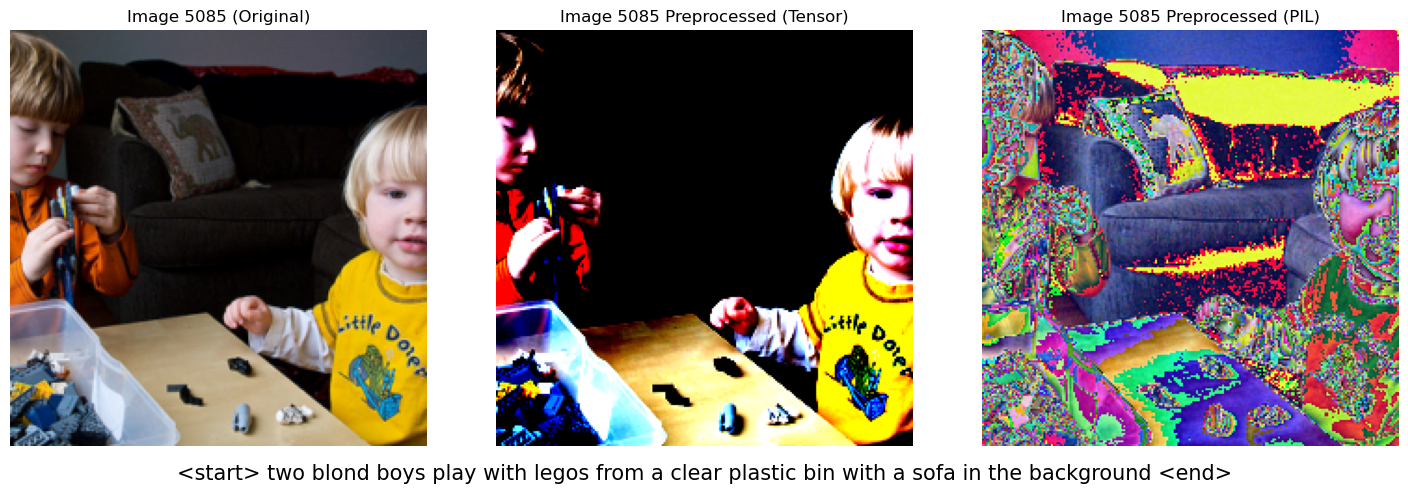

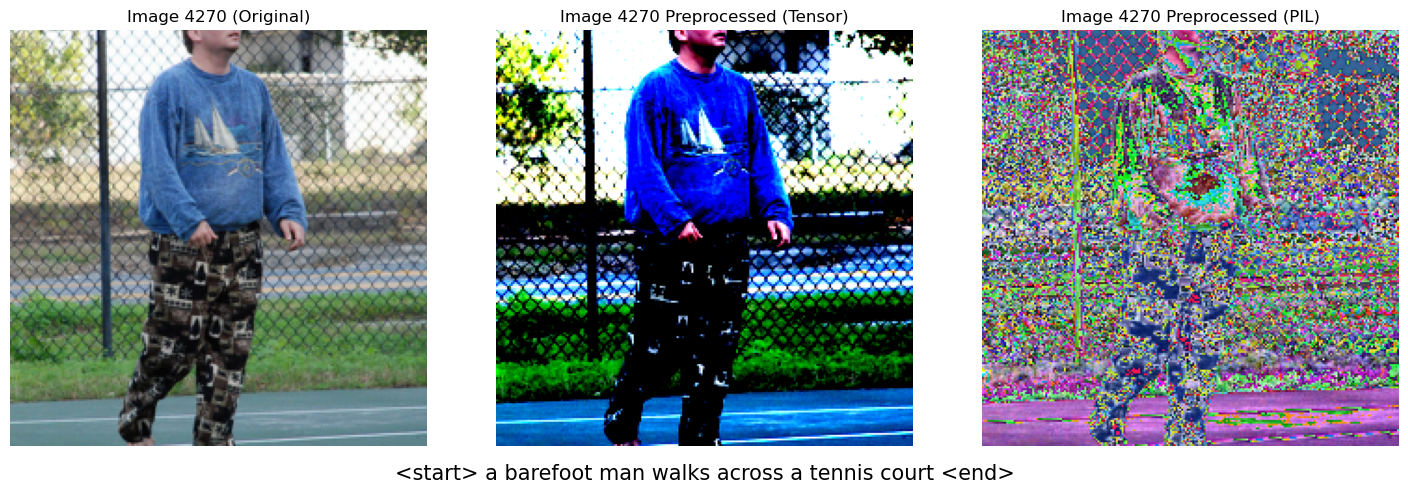

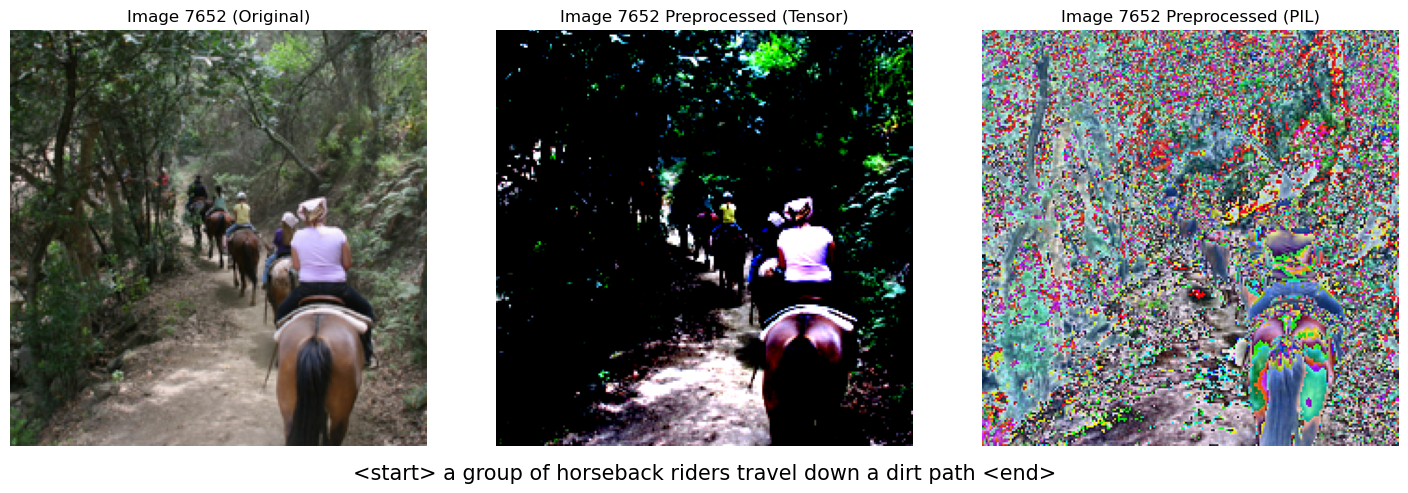

7282
809
809


In [6]:






#Visualization of 3 random images in training set
print("Size of the Dataset: ", len(dataset))

def tensor_to_pil_with_denormalization(tensor):
    """Convert tensor to denormalized PIL image."""
    mean = torch.tensor([0.485, 0.456, 0.406]).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(tensor.device)
    denormalized = tensor * std[:, None, None] + mean[:, None, None]
    denormalized = torch.clamp(denormalized, 0, 1)
    pil_img = ToPILImage()(denormalized)
    return pil_img


num_images_to_display = 3
rand_indices = random.sample(range(len(dataset)), num_images_to_display)

to_pil = ToPILImage()

for index in rand_indices:
    # Create a subplot with three columns (original, preprocessed, and denormalized preprocessed)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    # Get the image and its associated captions
    img, target = dataset[index]
        
    # Convert the tensor to a PIL image for the denormalized (unprocessed) image
    img_pil = tensor_to_pil_with_denormalization(img)
    axes[0].imshow(img_pil)
    axes[0].axis('off')
    axes[0].set_title(f"Image {index + 1} (Original)")
    
    # Convert the tensor to a PIL image for the preprocessed image
    axes[1].imshow(torch.clamp(img.permute(1, 2, 0), 0, 1))
    axes[1].axis('off')
    axes[1].set_title(f"Image {index + 1} Preprocessed (Tensor)")
    
    # Display the preprocessed image directly from tensor (rainbow effect)
    img_pil_preprocessed = to_pil(img)
    axes[2].imshow(img_pil_preprocessed)
    axes[2].axis('off')
    axes[2].set_title(f"Image {index + 1} Preprocessed (PIL)")

    if isinstance(target[0], int):  # Check if target is a single caption
        word_captions = ' '.join([idx_to_word[token] for token in target])
    else:  # If target contains multiple captions
        word_captions = [' '.join([idx_to_word[token] for token in caption]) for caption in target]
        word_captions = '\n'.join(word_captions)

    # Display the captions below the images (centered between them)
    fig.text(0.5, 0.01, word_captions, ha="center", va="bottom", size=15)
    
    plt.tight_layout(pad=3.0)
    plt.show()
    plt.close(fig)


### Initialzation and Data Splitting into Train and Validation sets, only necessary for Flickr Datasets

# Set seed for reproducibility
torch.manual_seed(0)

# Get the total number of samples in the dataset
num_samples = len(dataset)

# Shuffle the indices of the dataset
indices = torch.randperm(num_samples).tolist()

# Split indices based on your desired proportions
train_indices, val_indices = indices[:7282], indices[7282:]

flickrTrainSubset = Subset(dataset, train_indices)
flickrValSubset = Subset(dataset, val_indices)

#A duplicate of the Val subset to be able to use to calculate metrics like BLEU, METEOR, etc.
flickrEvalSubset = Subset(eval_dataset, val_indices)  


## Model Definition

This section contains the definitions for the different components of the model architecture. The model is built upon an Encoder-Decoder framework. Further enhancements, such as attention mechanisms and transformers, are planned for future iterations.

### CNN Encoder

The encoding layer of the model employs a Convolutional Neural Network (CNN) which will be pretrained using ResNet50. The CNN acts as a feature extractor which translates the input images into a condensed feature representation, suitable for the decoding layer. Below is the implementation of the `CNN_Encoder`:


In [7]:
class CNN_Encoder(nn.Module):
    def __init__(self, train_CNN=False, encoder_dim=config['encoder_dim']):
        super(CNN_Encoder, self).__init__()

        # Determine if the ResNet model should be trainable
        self.train_CNN = train_CNN

        # Load the pretrained ResNet model and remove its last classification layer
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        modules = list(resnet.children())[:-1]  
        self.resnet = nn.Sequential(*modules)

        # Set the ResNet layers to be trainable or not based on the flag
        self.resnet.requires_grad_(self.train_CNN)

        # Define the ReLU activation layer
        self.relu = nn.ReLU()  # Adding the ReLU activation

    def forward(self, images):

        # Extract features using the ResNet model
        features = self.resnet(images)  # In the shape [batch_size, 2048, 1, 1]
        features = features.squeeze(-1).squeeze(-1)  # Reshape to [batch_size, encoder_dim=2048]

        # Apply ReLU to introduce non-linearity
        features = self.relu(features)

        return features


### RNN Decoder

The decoding layer is comprised of a Recurrent Neural Network (RNN) using the Long Short-Term Memory (LSTM) architecture. The feature vector generated by the `CNN_Encoder` initializes the hidden state of the LSTM, allowing the `RNN_Decoder` to utilize image information for caption generation. Below is the `RNN_Decoder` implementation:


### Image Captioning Model

After defining the encoder and decoder, the next step is to integrate them into a single `Image_Captioning_Model`. This model will process the input image through the encoder, and then pass the resulting feature vector to the decoder to generate a corresponding caption. Below is the `Image_Captioning_Model` implementation:

In [8]:
class Image_Captioning_Model(nn.Module):
    def __init__(self, encoder, decoder):
        """
        Initialize the Image_Captioning_Model.
        :param encoder: The CNN encoder
        :param decoder: The RNN decoder
        """
        super(Image_Captioning_Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions, teacher_forcing_ratio=1.0):
        """
        Forward propagation.
        :param images: Images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :param captions: Captions, a tensor of dimensions (batch_size, max_caption_length)
        :return: Outputs, a tensor of dimensions (batch_size, max_caption_length, vocab_size)
        """
        features = self.encoder(images)
        outputs = self.decoder(features, captions, teacher_forcing_ratio=teacher_forcing_ratio)
        return outputs


### Training Helper functions

The training block was getting crowded with helper functions, so I moved them up here

## Model Training
With the data preprocessed and the model architecture defined, the next step is to train the model. This process involves feeding the input data (images and captions) into the model, which will adjust its internal parameters to minimize the difference between its predictions and the actual captions. The training process will iterate over the entire dataset multiple times, in what are known as epochs.



## Model Evaluation
After training the model, it is crucial to evaluate its performance to ensure it is learning and generating suitable captions for images. In this project, we employ the BLEU score (Bilingual Evaluation Understudy Score), a standard metric for assessing the quality of text generated by machine translation systems.

The BLEU score compares the generated captions (candidate sentences) with the actual captions (reference sentences) and assigns a score between 0 and 1, where 1 represents a perfect match with the reference. A higher BLEU score indicates better performance of the image captioning model.

In this section, we will compute the BLEU scores for the captions generated by the model on the test dataset and visualize the model's performance over time using matplotlib.

## Example Predictions

In this section, the trained model is utilized to generate captions for new, unseen images. This provides a practical demonstration of the model's capabilities and offers insight into its performance beyond numerical evaluation metrics. Observing the model's predictions on real-world examples can often reveal more nuanced information about its strengths and limitations.

For each image displayed below, the model’s predicted caption is presented alongside the image. This allows for a qualitative assessment of the model's captioning ability and aids in understanding the practical applicability of the model in real-world scenarios.


## Conclusion

This project has been an insightful journey for me, diving deep into the intricacies of machine learning, computer vision, and natural language processing. When I began this endeavor, I perceived Computer Vision and NLP as two separate domains. However, as the project unfolded, I realized the profound interconnectedness between them, which was a thrilling revelation.

Building an image captioning model, navigating the challenges, and witnessing its capabilities grow with each iteration has reinforced my passion for the world of Machine Learning. This experience has not just been about algorithms and architectures, but a testament to the potential of ML systems in making our world a better, more informed place.

The exploration and results obtained in this notebook underline the complexities and intricacies of image captioning. They also shed light on the performance and limitations of the model implemented. As I look to the future, I'm optimistic about delving deeper, refining this model, and unearthing more intersections between various AI domains.

The feedback and learnings from this work have provided me with a robust foundation for my continued journey in this fascinating field, and I'm eager to explore further, innovate, and contribute meaningfully to the world of AI.



## References

This section contains the list of references and resources used in the completion of this project. Proper citation acknowledges the contributions of others and provides a structured way to find additional information related to the topics and techniques discussed in this notebook. Each reference is listed with the appropriate citation, making it easy for readers to explore the source materials and gain deeper insights into the project and its underpinning methodologies.